# TUR-1097: CVM Forecast analysis

In [1]:
import sys
sys.path.insert(1, '/home/jovyan')
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
import util
PROJECT = 'gcp-wow-rwds-ai-mmm-super-dev'
import numpy as np

from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

### Full data

In [2]:
def get_data(df):
    return {
#         'Audience size': 'audience_size',
        'Incremental sales': 'inc_sales',
        'RPC': 'rpc',
        'Redemption rate': 'rdm_rate',
        'Cost': 'cost',
    }

In [3]:
SQL = '''
    WITH postbq_table AS (
        SELECT 
            campaign_start_date + CAST(7*(campaign_week_nbr-1) AS INT) AS campaign_week, 
            COUNT(1) AS audience_size,
            SUM(weekly_inc_sales) AS inc_sales, 
            SUM(redeem_flag) AS redemption,
        FROM `gcp-wow-rwds-ai-mmm-super-dev.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE`
        GROUP BY 1 ORDER BY 1
    ), 
    cost_table AS (
        SELECT 
            campaign_start_date + CAST(7*(campaign_week_nbr-1) AS INT) AS campaign_week,
            SUM(reward_val) AS cost
        FROM `wx-bq-poc.loyalty_bi_analytics.fact_campaign_sales` 
        WHERE campaign_code LIKE 'CVM-%'
        GROUP BY 1 ORDER BY 1
    )
    SELECT 
        pt.campaign_week,
        pt.audience_size,
        pt.inc_sales,
        pt.redemption / pt.audience_size AS rdm_rate,
        ct.cost,
        pt.inc_sales / pt.audience_size AS rpc
    FROM postbq_table pt 
        INNER JOIN cost_table ct 
            ON pt.campaign_week = ct.campaign_week
    ORDER BY 1
'''
df_weekly = util.sql2df(PROJECT, SQL)
df_weekly = df_weekly[:-1]

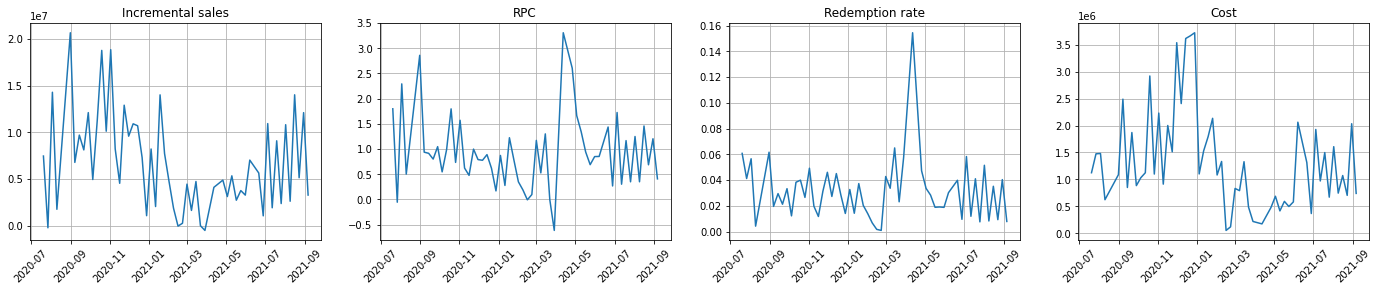

In [4]:
data = get_data(df_weekly)

fig, ax = plt.subplots(1, 4, figsize=(24, 4))
for i, (k, v) in enumerate(data.items()):
    ax[i].set_title(k)
    ax[i].plot(df_weekly['campaign_week'], df_weekly[v])
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(45)
    ax[i].grid()    
plt.show()

In [5]:
SQL = '''
    WITH postbq_table AS (
        SELECT 
            LAST_DAY(campaign_start_date + CAST(7*(campaign_week_nbr-1) AS INT)) AS campaign_month, 
            COUNT(1) AS audience_size,
            SUM(weekly_inc_sales) AS inc_sales, 
            SUM(redeem_flag) AS redemption,
        FROM `gcp-wow-rwds-ai-mmm-super-dev.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE`
        GROUP BY 1 ORDER BY 1
    ), 
    cost_table AS (
        SELECT 
            LAST_DAY(campaign_start_date + CAST(7*(campaign_week_nbr-1) AS INT)) AS campaign_month,
            SUM(reward_val) AS cost
        FROM `wx-bq-poc.loyalty_bi_analytics.fact_campaign_sales` 
        WHERE campaign_code LIKE 'CVM-%'
        GROUP BY 1 ORDER BY 1
    )
    SELECT 
        pt.campaign_month,
        pt.audience_size,
        pt.inc_sales,
        pt.redemption / pt.audience_size AS rdm_rate,
        ct.cost,
        pt.inc_sales / pt.audience_size AS rpc
    FROM postbq_table pt 
        INNER JOIN cost_table ct 
            ON pt.campaign_month = ct.campaign_month
    WHERE pt.campaign_month < '2021-09-01'
    ORDER BY 1
'''
df_monthly = util.sql2df(PROJECT, SQL)

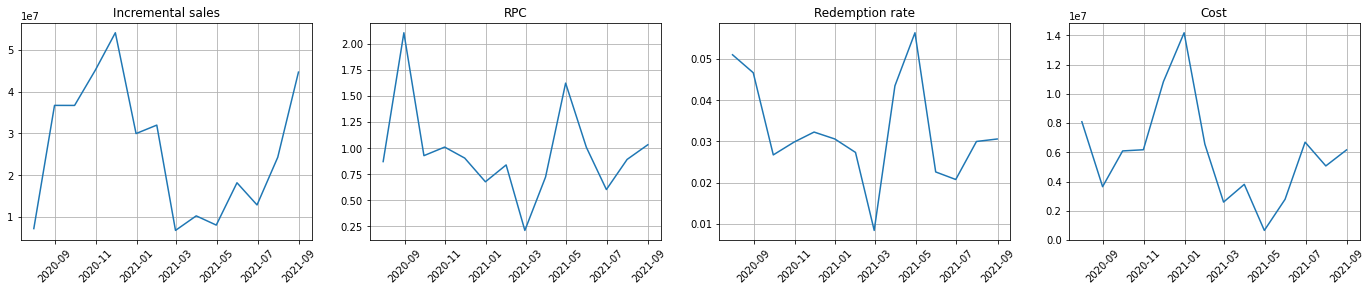

In [6]:
data = get_data(df_monthly)

fig, ax = plt.subplots(1, 4, figsize=(24, 4))
for i, (k, v) in enumerate(data.items()):
    ax[i].set_title(k)
    ax[i].plot(df_monthly.campaign_month, df_monthly[v])
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(45)
    ax[i].grid()    
plt.show()

### Dummy ARIMA

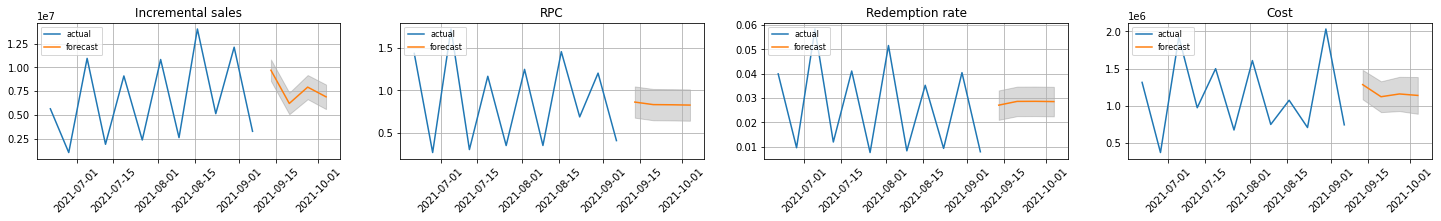

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(25, 2.5))

for i, (k, v) in enumerate(data.items()):
    model = ARIMA(df_weekly[v].astype(float), order=(1, 1, 1))  
    fitted = model.fit(disp=-1)  

    # Forecast
    fc, se, conf = fitted.forecast(4, alpha=0.8) # very low confidence for illustration purposes
    actual = df_weekly[['campaign_week', v]]
    forecast = pd.DataFrame({
        'campaign_week': [
            '2021-09-13', '2021-09-20', '2021-09-27', '2021-10-04'
        ],
        v: fc
    })
    combined = actual.append(forecast).reset_index(drop=True)
    combined['campaign_week'] = pd.to_datetime(combined['campaign_week'])
    combined.set_index('campaign_week', inplace=True)
    actual = combined[v][-16:-4]
    forecast = combined[v][-4:]

    # Make as pandas series
    lower_series = pd.Series(conf[:, 0], index = forecast.index)
    upper_series = pd.Series(conf[:, 1], index = forecast.index)

    # Plot
    ax[i].set_title(k)
    ax[i].plot(actual, label='actual')
    ax[i].plot(forecast, label='forecast')
    ax[i].fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    ax[i].legend(loc='upper left', fontsize=8)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(45)
    ax[i].grid()

plt.show()

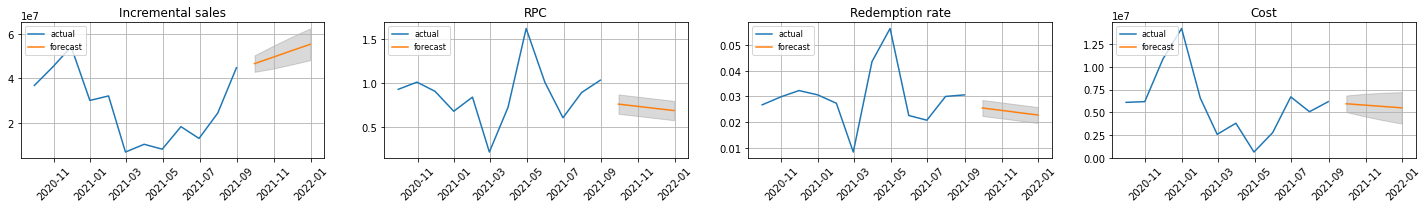

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(25, 2.5))

for i, (k, v) in enumerate(data.items()):
    model = ARIMA(df_monthly[v].astype(float), order=(0, 1, 1))  
    fitted = model.fit(disp=-1)  

    # Forecast
    fc, se, conf = fitted.forecast(4, alpha=0.8) # very low confidence for illustration purposes
    actual = df_monthly[['campaign_month', v]]
    forecast = pd.DataFrame({
        'campaign_month': ['2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31'],
        v: fc
    })
    combined = actual.append(forecast).reset_index(drop=True)
    combined['campaign_month'] = pd.to_datetime(combined['campaign_month'])
    combined.set_index('campaign_month', inplace=True)
    actual = combined[v][-16:-4]
    forecast = combined[v][-4:]

    # Make as pandas series
    lower_series = pd.Series(conf[:, 0], index = forecast.index)
    upper_series = pd.Series(conf[:, 1], index = forecast.index)

    # Plot
    ax[i].set_title(k)
    ax[i].plot(actual, label='actual')
    ax[i].plot(forecast, label='forecast')
    ax[i].fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    ax[i].legend(loc='upper left', fontsize=8)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(45)
    ax[i].grid()
    
plt.show()

#### Vanilla ARIMA 

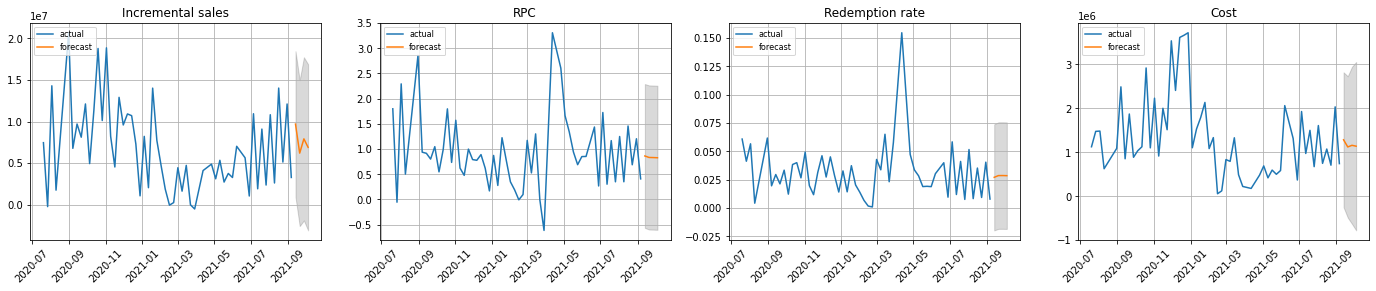

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(24, 4))

for i, (k, v) in enumerate(data.items()):
    model = ARIMA(df_weekly[v].astype(float), order=(1, 1, 1))  
    fitted = model.fit(disp=-1)  

    # Forecast
    fc, se, conf = fitted.forecast(4, alpha=0.05) # very low confidence for illustration purposes
    actual = df_weekly[['campaign_week', v]]
    forecast = pd.DataFrame({
        'campaign_week': [
            '2021-09-13', '2021-09-20', '2021-09-27', '2021-10-04',
        ],
        v: fc
    })
    combined = actual.append(forecast).reset_index(drop=True)
    combined['campaign_week'] = pd.to_datetime(combined['campaign_week'])
    combined.set_index('campaign_week', inplace=True)
    actual = combined[v][:-4]
    forecast = combined[v][-4:]

    # Make as pandas series
    lower_series = pd.Series(conf[:, 0], index = forecast.index)
    upper_series = pd.Series(conf[:, 1], index = forecast.index)

    # Plot
    ax[i].set_title(k)
    ax[i].plot(actual, label='actual')
    ax[i].plot(forecast, label='forecast')
    ax[i].fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    ax[i].legend(loc='upper left', fontsize=8)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(45)
    ax[i].grid()

plt.show()

### Campaign breakdown - using incremental sales only (for demo)

In [27]:
SQL = '''
    WITH weeks AS (
        SELECT *
        FROM UNNEST(GENERATE_DATE_ARRAY('2020-07-20', '2021-08-30', INTERVAL 7 DAY)) AS campaign_week
    ), campaign AS (
        SELECT DISTINCT offer_type
        FROM `gcp-wow-rwds-ai-mmm-super-dev.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE`
    ), campaign_cross_weeks AS (
        SELECT *
        FROM weeks CROSS JOIN campaign
    ), postbq_table AS (
        SELECT 
            offer_type,
            campaign_start_date + CAST(7*(campaign_week_nbr-1) AS INT) AS campaign_week, 
            SUM(weekly_inc_sales) AS inc_sales, 
        FROM `gcp-wow-rwds-ai-mmm-super-dev.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE`
        GROUP BY 1,2 ORDER BY 1,2
    )
    SELECT 
        cw.offer_type,
        cw.campaign_week,
        pt.inc_sales
    FROM campaign_cross_weeks cw 
        LEFT JOIN postbq_table pt 
            ON cw.campaign_week = pt.campaign_week
            AND cw.offer_type = pt.offer_type
    ORDER BY 1,2
    
'''
df_camp_weekly = util.sql2df(PROJECT, SQL)

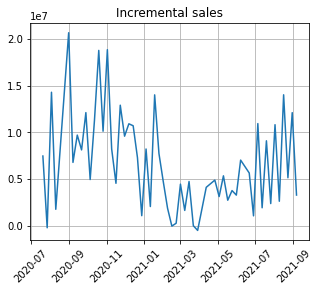

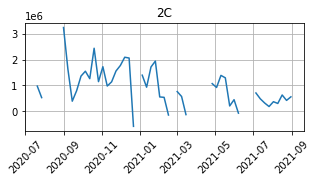

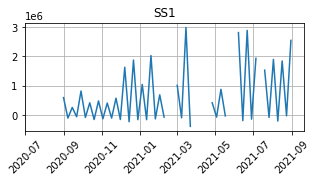

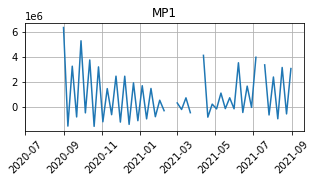

In [42]:
plt.figure(figsize=(5, 4))
plt.title('Incremental sales')
plt.plot(df_weekly['campaign_week'], df_weekly['inc_sales'])
plt.xticks(rotation=45)
plt.grid()


for campaign in ['2C', 'SS1', 'MP1']:
    plt_df = df_camp_weekly[df_camp_weekly['offer_type'] == campaign]
    plt.figure(figsize=(5, 2))
    plt.title(campaign)
    plt.plot(plt_df['campaign_week'], plt_df['inc_sales'])
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()